In [2]:
import pickle
import numpy as np
from sklearn.metrics import accuracy_score
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

## Download the train states from Kaggle
They can be found in the output of the following notebooks
- [Notebook/Weights for English Dataset](https://www.kaggle.com/coseck/fork-of-electra-on-pan-fake-news-2b295d)
- [Notebook/Weights for Spanish Dataset](https://www.kaggle.com/coseck/spanish-electra-on-pan-fake-news)

In [4]:
en_train_state = 'train_states/train_states_en.pickle'
es_train_state = 'train_states/train_states_es.pickle'

In [5]:
with open(es_train_state,'rb') as f:
    ts_es = pickle.load(f)

with open(en_train_state,'rb') as f:
    ts_en = pickle.load(f)

In [6]:
def sort_preds(indexes, preds):
    """Sorts the predictions in order, to reverse the effects of shuffle
    done by dataloader"""
    indexes = indexes.cpu().numpy().reshape(-1,1)
    preds = preds.cpu().numpy()
    arr_concat = np.hstack((indexes,preds)) #concat the preds and their indexes    
    sort_arr = arr_concat[ arr_concat[:,0].argsort()] #sort based on the indexes
    sorted_preds = np.delete(sort_arr,0,axis=1)
    return sorted_preds,sort_arr

def get_optimal_models(train_state, split, reverse=False ):
    """Naive Ensembling"""
    trgts= sort_preds(train_state[f'{split}_indexes'][-1],train_state[f'{split}_targets'][-1].reshape(-1,1))
    total_preds = len(train_state[f'{split}_indexes'])
    init = np.zeros(train_state[f'{split}_preds'][-1].shape)
    max_f1 = 0
    idxes = []
    rng = range(0,total_preds)
    if reverse:
        rng = reversed(rng)
    for i in rng:
        temp = sort_preds(train_state[f'{split}_indexes'][i],train_state[f'{split}_preds'][i])
        temp2 = init+temp
        f1 = f1_score(
            y_pred=temp2.argmax(axis=1),
            y_true= trgts, average ='weighted'
        )
        if f1 > max_f1:
            max_f1 = f1
            init = init+temp
            idxes.append(i)
    print(f'Taking preds from {idxes} | Dev f1:{f1}')
    return (idxes,max_f1)

In [7]:
def majority_voting(ts):
    _val_targets,_ = sort_preds(
        ts[0]['val_indexes'][0],
        ts[0]['val_targets'][0].reshape((-1,1))
    )

    init = np.zeros(ts[0]['val_preds'][0].shape)
    prev_acc = 0
    all_preds =  []
    pred_list = []
    for i in range(len(ts)):

        _best_pred_idx = np.argmax(ts[i]['val_accuracies'])
        _val_preds,_ = sort_preds(
            ts[i]['val_indexes'][_best_pred_idx],
            ts[i]['val_preds'][_best_pred_idx]
        )
        
        curr_acc = accuracy_score(
                    y_pred=_val_preds.argmax(axis=1),
                    y_true= _val_targets,
                )
        pred_list.append(curr_acc)
#         print(i, curr_acc)

        all_preds.append(_val_preds.argmax(axis=1))
    ballot = np.column_stack(all_preds)
    acc = accuracy_score(
                    y_pred=[collections.Counter(l).most_common(1)[0][0] for l in ballot.tolist()],
                    y_true= _val_targets,
                )
    df = pd.DataFrame({
        'model' : [i for i in range(1, len(ts)+1)],
        'accuracy' : pred_list
    })
    return acc,df
    
    
def soft_voting(ts):
    _val_targets,_ = sort_preds(
        ts[0]['val_indexes'][0],
        ts[0]['val_targets'][0].reshape((-1,1))
    )

    init = np.zeros(ts[0]['val_preds'][0].shape)

    for i in range(len(ts)):

        _best_pred_idx = np.argmax(ts[i]['val_accuracies'])
        _val_preds,_ = sort_preds(
            ts[i]['val_indexes'][_best_pred_idx],
            ts[i]['val_preds'][_best_pred_idx]
        )

        init = init + _val_preds

        acc = accuracy_score(
                    y_pred=init.argmax(axis=1),
                    y_true= _val_targets,
                )

        print(acc, np.max(ts[i]['val_accuracies']))

# Analysing English Ensemble Validation set Performance

In [8]:
maj_acc_en,en_acc_df = majority_voting(ts_en)
en_acc_df.rename(columns={'accuracy':'en_accuracy'}, inplace=True)

In [9]:
en_acc_df

,model,en_accuracy
0,1,0.733333
1,2,0.800000
2,3,0.766667
3,4,0.766667
4,5,0.766667
5,6,0.833333
6,7,0.800000
7,8,0.733333
8,9,0.733333
9,10,0.800000


In [10]:
maj_acc_en

0.8666666666666667

# Analysing Spanish Ensemble Validation set Performance

In [11]:
maj_acc_es,es_acc_df = majority_voting(ts_es)
es_acc_df.rename(columns={'accuracy':'es_accuracy'}, inplace=True)

In [12]:
maj_acc_es

0.7666666666666667

In [13]:
es_acc_df

,model,es_accuracy
0,1,0.733333
1,2,0.833333
2,3,0.733333
3,4,0.766667
4,5,0.766667
5,6,0.733333
6,7,0.766667
7,8,0.766667
8,9,0.766667
9,10,0.833333


In [14]:
ensemble_acc_df = pd.merge(es_acc_df, en_acc_df, on='model')

In [15]:
ensemble_acc_df

,model,es_accuracy,en_accuracy
0,1,0.733333,0.733333
1,2,0.833333,0.800000
2,3,0.733333,0.766667
3,4,0.766667,0.766667
4,5,0.766667,0.766667
5,6,0.733333,0.833333
6,7,0.766667,0.800000
7,8,0.766667,0.733333
8,9,0.766667,0.733333
9,10,0.833333,0.800000


No handles with labels found to put in legend.


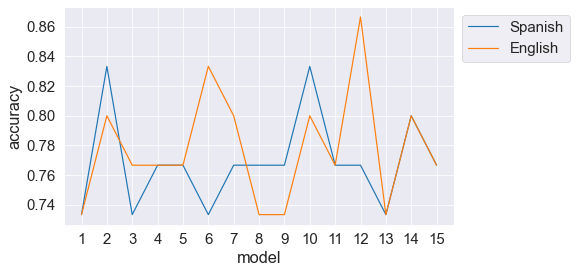

In [16]:
with sns.plotting_context('paper',font_scale=1.7):
    fig, ax = plt.subplots(figsize=(7,4))
    sns.lineplot(x='model', y='es_accuracy' ,data=ensemble_acc_df,ax=ax)
    sns.lineplot(x='model', y='en_accuracy' ,data=ensemble_acc_df,ax=ax)
    plt.xlabel('model')
    plt.ylabel('accuracy')
    plt.legend()
    plt.xticks(ensemble_acc_df.model)
    plt.legend(['Spanish','English'], bbox_to_anchor=(1,1), loc="upper left")

#     fig.savefig("ensemble_accs.pdf", bbox_inches="tight") 
    